In [1]:
import algo_func
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg
import matplotlib
import scipy as sp
import importlib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('elec_data.csv',index_col = 0)
scaler = StandardScaler()
ot = np.expand_dims(data['OT'].array,axis =1)
ot_ = scaler.fit_transform(ot)

train,valid,test = ot_[0:10_000],ot_[10_000:11_000],ot_[11_000:]

fil_order = 7
train,val,test = ot_[0:10_000],ot_[10_000:11_000],ot_[11_000:]

ip_train = train
op_train = train[fil_order+1:]

ip_val = val
op_val = val[fil_order+1:]

ip_test = test
op_test = test[fil_order+1:]

In [72]:
### finding e_lms_mse

step_size_best = 0.0029

y,e_lms_mse,w = algo_func.lms_mse(ip_train,op_train,fil_order,step_size_best)
print(algo_func.mse(ip_train,op_train,w[-1])[0])
print(algo_func.mse(ip_val,op_val,w[-1])[0])
print(algo_func.mse(ip_test,op_test,w[-1])[0])

0.0012402574052415003
0.0009483272754592175
0.0009330833764414353


In [5]:
def pred(ip,w):
    
    ip = ip[:,0]
    len_w = len(w)
    y = sg.lfilter(w,1,ip)
    y = y[len_w:]
    
    return y

In [73]:
y_lms_mse = pred(ip_val,w[-1])

In [74]:
kern_size_arr = [0.25]
step_size_arr = [0.00065]
k1,k2 = len(kern_size_arr),len(step_size_arr)

print(k1,k2)

mse_train_step = np.zeros((k1,k2))
mse_val_step = np.zeros((k1,k2))
mse_test_step = np.zeros((k1,k2))
for i in tqdm(range(k1)):
    
    kern_size = kern_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,e_lms_mcc,w = algo_func.lms_mcc(ip_train,op_train,fil_order,step_size,kern_size)
        mse_train_step[i][j]=algo_func.mse(ip_train,op_train,w[-1])[0]
        mse_val_step[i][j] = algo_func.mse(ip_val,op_val,w[-1])[0]
        mse_test_step[i][j] = algo_func.mse(ip_test,op_test,w[-1])[0]
        
print(mse_train_step)
print(mse_val_step)
print(mse_test_step)

1 1


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]

[[0.00101718]]
[[0.00080185]]
[[0.00069347]]


In [75]:
y_lms_mcc = pred(ip_val,w[-1])

In [13]:
#### for kernel filter with best mse

rk_size_arr = [0.922] # the best chosen from previous project , above values are overfitting
step_size_arr = [0.109]

k1,k2 = len(rk_size_arr),len(step_size_arr)

print(k1,k2)

klms_mse_train = np.zeros((k1,k2))
klms_mse_val = np.zeros((k1,k2))
klms_mse_test = np.zeros((k1,k2))

fil_order = 7

for i in tqdm(range(k1)):
    
    rk_size = rk_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,e_klms_mse,centers,cnt = algo_func.KLMS_mse_2(ip_train,op_train,fil_order,rk_size,step_size)
        klms_mse_train[i][j] = algo_func.klms_mseror(ip_train,op_train,fil_order,e_klms_mse,centers,rk_size,step_size)[0]
        klms_mse_val[i][j] = algo_func.klms_mseror(ip_val,op_val,fil_order,e_klms_mse,centers,rk_size,step_size)[0]
        klms_mse_test[i][j] = algo_func.klms_mseror(ip_test,op_test,fil_order,e_klms_mse,centers,rk_size,step_size)[0]
        
print(klms_mse_train)
print(klms_mse_val)
print(klms_mse_test)

1 1


100%|███████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it]

[[0.01400795]]
[[0.0092154]]
[[0.05692478]]


In [69]:
y_klms_mse = algo_func.klms_pred(ip_val,op_val,fil_order,e_klms_mse,centers,rk_size_arr[0],step_size_arr[0])

In [120]:
rk_size_arr = [1.4]
step_size_arr = [0.02]
kern_size_arr = [0.8]

k1,k2 = len(rk_size_arr),len(step_size_arr)

print(k1,k2)

k3 = len(kern_size_arr)

klms_mcc_train = np.zeros((k1,k2))
klms_mcc_val = np.zeros((k1,k2))
klms_mcc_test = np.zeros((k1,k2))


for i in tqdm(range(k1)):
    
    rk_size = rk_size_arr[i]
    
    for j in range(k2):
    
            
        step_size = step_size_arr[j]
        kern_size = kern_size_arr[0]
        y,e_klms_mcc,centers,cnt = algo_func.KLMS_mcc_2(ip_train,op_train,fil_order,rk_size,step_size,kern_size)
        step_size = step_size/(kern_size**2)
        klms_mcc_train[i][j] = algo_func.klms_mseror(ip_train,op_train,fil_order,e_klms_mcc,centers,rk_size,step_size)[0]
        klms_mcc_val[i][j] = algo_func.klms_mseror(ip_val,op_val,fil_order,e_klms_mcc,centers,rk_size,step_size)[0]
        klms_mcc_test[i][j],klms_mcc_test_e = algo_func.klms_mseror(ip_test,op_test,fil_order,e_klms_mcc,centers,rk_size,step_size)

print(klms_mcc_train)        
print(klms_mcc_val)
print(klms_mcc_test)

1 1


100%|███████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]

[[0.07069177]]
[[0.03639964]]
[[0.08384684]]


In [87]:
y_klms_mcc = algo_func.klms_pred(ip_val,op_val,fil_order,e_klms_mcc,centers,rk_size_arr[0],step_size_arr[0])

In [109]:
rk_size_arr = [0.39]
step_size_arr = [0.9]
threshold = 0.2
k1,k2 = len(rk_size_arr),len(step_size_arr)

print(k1,k2)

klms_mse_train = np.zeros((k1,k2))
klms_mse_val = np.zeros((k1,k2))
klms_mse_test = np.zeros((k1,k2))

fil_order = 7

for i in tqdm(range(k1)):
    
    rk_size = rk_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,e_qklms_mse,centers,alpha,cnt = algo_func.QKLMS_mse_2(ip_train,op_train,fil_order,rk_size,step_size,threshold)
        klms_mse_train[i][j] = algo_func.klms_mseror(ip_train,op_train,fil_order,alpha,centers,rk_size,step_size)[0]
        klms_mse_val[i][j] = algo_func.klms_mseror(ip_val,op_val,fil_order,alpha,centers,rk_size,step_size)[0]
        klms_mse_test[i][j] = algo_func.klms_mseror(ip_test,op_test,fil_order,alpha,centers,rk_size,step_size)[0]

1 1


100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


In [115]:
#uptil now best k = 0.4 and eta = 0.9
# this is for QKLMS with MSE
rk_size_arr = [0.39]
step_size_arr = [0.9]
threshold_arr = np.concatenate((np.linspace(0.01,0.1,10),np.linspace(0.1,1,10)))
cnt_arr = []

k1,k2 = len(rk_size_arr),len(step_size_arr)
k3 = len(threshold_arr)
#print(k1,k2)

qklms_mse_val = np.zeros((k3,1))
qklms_mse_test = np.zeros((k3,1))

for i in tqdm(range(k3)):
    
    rk_size = rk_size_arr[0]
    step_size = step_size_arr[0]
    threshold = threshold_arr[i]
    y,e,centers,alpha,cnt = algo_func.QKLMS_mse_2(ip_train,op_train,fil_order,rk_size,step_size,threshold)
    qklms_mse_val[i] = algo_func.klms_mseror(ip_val,op_val,fil_order,alpha,centers,rk_size,step_size)[0]
    qklms_mse_test[i] = algo_func.klms_mseror(ip_test,op_test,fil_order,alpha,centers,rk_size,step_size)[0]
    cnt_arr.append(cnt[-1])

100%|█████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


Text(0, 0.5, 'Network size')

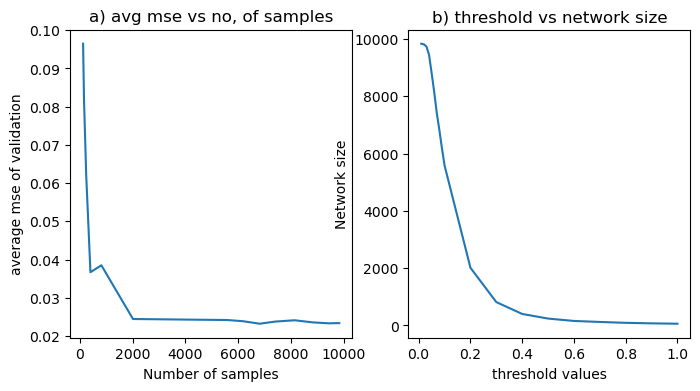

In [117]:
fig,ax = plt.subplots(ncols=2,figsize =(8,4))
ax[0].plot(cnt_arr[:-3],qklms_mse_val[:-3])
ax[0].set_title('a) avg mse vs no, of samples')
ax[0].set_xlabel('Number of samples')
ax[0].set_ylabel('average mse of validation')
ax[1].plot(threshold_arr,cnt_arr)
ax[1].set_title('b) threshold vs network size')
ax[1].set_xlabel('threshold values')
ax[1].set_ylabel('Network size')

In [111]:
print(klms_mse_train)        
print(klms_mse_val)
print(klms_mse_test)

[[0.04048675]]
[[0.02442292]]
[[0.12441412]]


In [102]:
y_qklms_mse = algo_func.klms_pred(ip_val,op_val,fil_order,alpha,centers,rk_size_arr[0],step_size_arr[0])

In [112]:
rk_size_arr = [0.39]
step_size_arr = [0.9]
threshold = 0.2
k1,k2 = len(rk_size_arr),len(step_size_arr)

print(k1,k2)

klms_mse_train = np.zeros((k1,k2))
klms_mse_val = np.zeros((k1,k2))
klms_mse_test = np.zeros((k1,k2))

fil_order = 7

for i in tqdm(range(k1)):
    
    rk_size = rk_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,e_qklms_mcc,centers,alpha,cnt = algo_func.QKLMS_mcc_2(ip_train,op_train,fil_order,rk_size,step_size,threshold,2)
        klms_mse_train[i][j] = algo_func.klms_mseror(ip_train,op_train,fil_order,alpha,centers,rk_size,step_size)[0]
        klms_mse_val[i][j] = algo_func.klms_mseror(ip_val,op_val,fil_order,alpha,centers,rk_size,step_size)[0]
        klms_mse_test[i][j] = algo_func.klms_mseror(ip_test,op_test,fil_order,alpha,centers,rk_size,step_size)[0]

1 1


100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


In [113]:
print(klms_mse_train)        
print(klms_mse_val)
print(klms_mse_test)

[[0.05159797]]
[[0.03198566]]
[[0.13942427]]


In [104]:
y_qklms_mcc = algo_func.klms_pred(ip_val,op_val,fil_order,alpha,centers,rk_size_arr[0],step_size_arr[0])

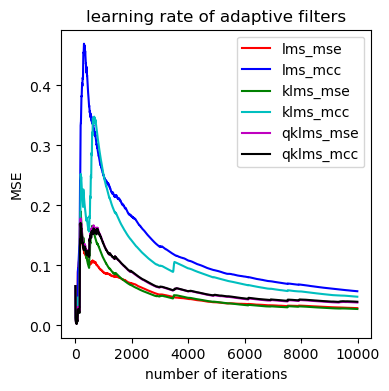

In [105]:
### convergence plot for these methods. 

fig = plt.figure(figsize = (4,4))
plt.plot(algo_func.learn_curve(e_lms_mse),'-r',label = 'lms_mse')
plt.plot(algo_func.learn_curve(e_lms_mcc),'-b',label = 'lms_mcc')
plt.plot(algo_func.learn_curve(e_klms_mse),'-g',label = 'klms_mse')
plt.plot(algo_func.learn_curve(e_klms_mcc),'-c',label = 'klms_mcc')
plt.plot(algo_func.learn_curve(e_qklms_mse),'-m',label = 'qklms_mse')
plt.plot(algo_func.learn_curve(e_qklms_mcc),'-k',label = 'qklms_mcc')
plt.xlabel('number of iterations')
plt.ylabel('MSE')
plt.title('learning rate of adaptive filters')
plt.legend()

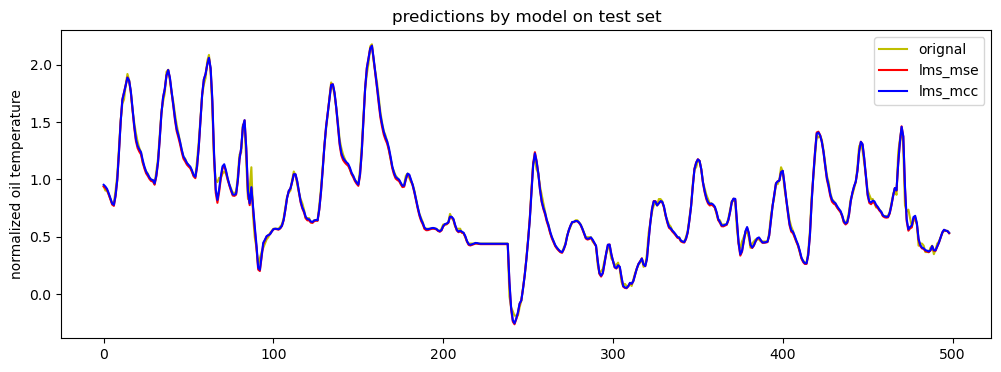

In [108]:
fig = plt.figure(figsize = (12,4))
plt.plot(op_val[1:500],'-y',label = 'orignal')
plt.plot(y_lms_mse[1:500],'-r',label = 'lms_mse')
plt.plot(y_lms_mcc[1:500],'-b',label = 'lms_mcc')
plt.ylabel('normalized oil temperature')
plt.title('predictions by model on test set')
plt.legend()

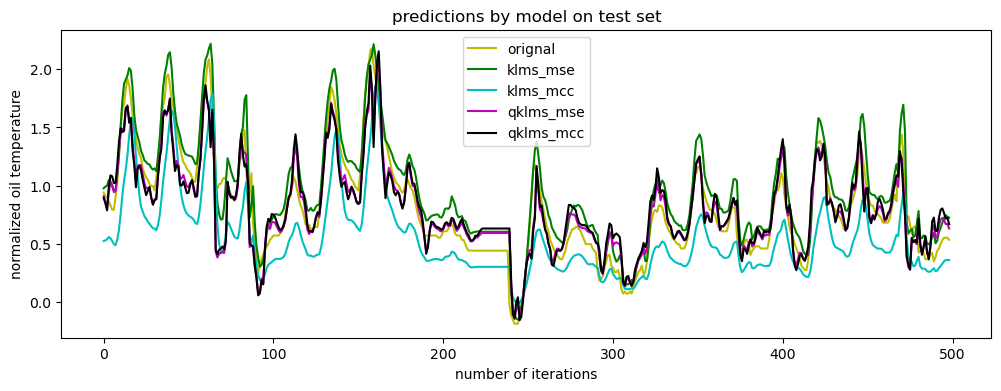

In [107]:
fig = plt.figure(figsize = (12,4))
plt.plot(op_val[1:500],'-y',label = 'orignal')
plt.plot(y_klms_mse[1:500],'-g',label = 'klms_mse')
plt.plot(y_klms_mcc[1:500],'-c',label = 'klms_mcc')
plt.plot(y_qklms_mse[1:500],'-m',label = 'qklms_mse')
plt.plot(y_qklms_mcc[1:500],'-k',label = 'qklms_mcc')
plt.xlabel('number of iterations')
plt.ylabel('normalized oil temperature')
plt.title('predictions by model on test set')
plt.legend()

In [122]:
ot_threshold = 0.2*np.std(ip_train)
ot_threshold

0.20333503883700177

In [123]:
### Trajectory generation

rk_size_arr = [0.922] # the best chosen from previous project , above values are overfitting
step_size_arr = [0.109]

k1,k2 = len(rk_size_arr),len(step_size_arr)

print(k1,k2)

fil_order = 7

for i in range(k1):
    
    rk_size = rk_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,e,centers,_ = algo_func.KLMS_mse_2(ip_train,op_train,fil_order,rk_size,step_size)
        print(algo_func.klms_mseror(ip_train,op_train,fil_order,e,centers,rk_size,step_size)[0])
        #print(algo_func.mse_klms_ahead(ip_train,op_train,fil_order,e,centers,rk_size,step_size,10))
        #print(algo_func.mse_klms_ahead(ip_train,op_train,fil_order,e,centers,rk_size,step_size,50))

    
    
cnt_arr_klms_mse = []
cnt_max = 0
p_max = 0

for i in range(8,len(op_train)-1000):

    init_pos = i
    _,cnt,_ = algo_func.klms_trac_gen(ip_train,op_train,fil_order,e,centers,rk_size,step_size,init_pos,ot_threshold)
    
    if cnt>cnt_max:
        
        p_max = init_pos
        cnt_max = cnt
        
    cnt_arr_klms_mse.append(cnt)

np.average(cnt_arr_klms_mse)

1 1
0.014007948379793474


4.33926981300089

In [124]:
rk_size_arr = [1.4]
step_size_arr = [0.02]
kern_size_arr = [0.8]


fil_order = 7


    
rk_size = rk_size_arr[0]

    
            
step_size = step_size_arr[0]
kern_size = kern_size_arr[0]
y,e,centers,cnt = algo_func.KLMS_mcc_2(ip_train,op_train,fil_order,rk_size,step_size,kern_size)
step_size = step_size/(kern_size**2)
#klms_mcc_val[i][j] = algo_func.klms_mseror(ip_val,op_val,fil_order,e,centers,rk_size,step_size)


print('for the training dataset')

print(algo_func.klms_mseror(ip_train,op_train,fil_order,e,centers,rk_size,step_size)[0])


cnt_arr_klms_mcc = []
cnt_max = 0
p_max = 0

for i in range(8,len(op_train)-1000):

    init_pos = i
    _,cnt,_ = algo_func.klms_trac_gen(ip_train,op_train,fil_order,e,centers,rk_size,step_size,init_pos,ot_threshold)
    
    if cnt>cnt_max:
        
        p_max = init_pos
        cnt_max = cnt
        
    cnt_arr_klms_mcc.append(cnt)

np.average(cnt_arr_klms_mcc)

        
#print(klms_mcc_val)
#print(klms_mcc_test)

for the training dataset
0.07069176608574415


3.2435440783615315

In [126]:
step_size_best = 0.0029
fil_order = 7

ip_train = train
op_train = train[fil_order+1:]

ip_val = valid
op_val = valid[fil_order+1:]

y,e,w = algo_func.lms_mse(ip_train,op_train,fil_order,step_size_best)
print(algo_func.mse(ip_train,op_train,w[-1])[0])
print(algo_func.mse(ip_val,op_val,w[-1])[0])

cnt_arr_lms_mse = []
cnt_max = 0
p_max = 0
for i in range(8,len(op_train)-500):

    init_pos = i
    y_trac,cnt,_ = algo_func.lms_trac_gen(ip_train,op_train,w[-1],init_pos,ot_threshold)
    if cnt>cnt_max:
        
        p_max = init_pos
        cnt_max_mse = cnt
        
    cnt_arr_lms_mse.append(cnt)

np.average(cnt_arr_lms_mse)

0.0012402574052415003
0.0009483272754592175


7.034057359763812

In [132]:
step_size_best = 0.00065
kern_size_best = 0.25

fil_order = 7

ip_train = train
op_train = train[fil_order+1:]

ip_val = valid
op_val = valid[fil_order+1:]

_,_,w = algo_func.lms_mcc(ip_train,op_train,fil_order,step_size_best,kern_size_best)

print(algo_func.mse(ip_train,op_train,w[-1])[0])
print(algo_func.mse(ip_val,op_val,w[-1])[0])


cnt_arr_lms_mcc = []
cnt_max = 0
p_max = 0
for i in range(8,len(op_train)-500):

    init_pos = i
    y_trac,cnt,_ = algo_func.lms_trac_gen(ip_train,op_train,w[-1],init_pos,ot_threshold)
    
    if cnt>cnt_max:
        
        p_max = init_pos
        cnt_max = cnt
        
    cnt_arr_lms_mcc.append(cnt)

np.average(cnt_arr_lms_mcc)

0.0010171756421849315
0.0008018532737344571


7.315267819485449

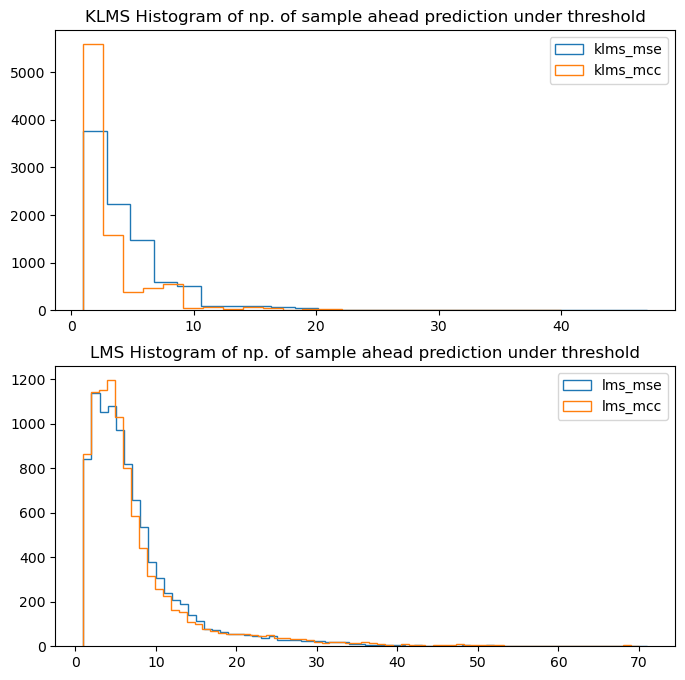

In [133]:
fig,axs = plt.subplots(nrows = 2,figsize = (8,8))
_ = axs[0].hist(cnt_arr_klms_mse,bins = 24,label = 'klms_mse',histtype = 'step')
_ = axs[0].hist(cnt_arr_klms_mcc,bins = 24,label = 'klms_mcc',histtype = 'step')
axs[0].set_title('KLMS Histogram of np. of sample ahead prediction under threshold')
axs[0].legend()

_ = axs[1].hist(cnt_arr_lms_mse,bins = 70,label = 'lms_mse',histtype = 'step')
_ = axs[1].hist(cnt_arr_lms_mcc,bins = 70,label = 'lms_mcc',histtype = 'step')
axs[1].set_title('LMS Histogram of np. of sample ahead prediction under threshold')
axs[1].legend()